# Saving Experiment Data to the Cloud

Qiskit Experiments is designed to work with Qiskit's online experiment database, where you can view and share results of experiments you've run. This tutorial shows how to save your experimental results to the database. You will need to have `qiskit-ibmq-provider` installed locally and an account in the Qiskit cloud service. We will use the `ibmq_armonk` backend which is open and available to everyone.

In [1]:
from qiskit import IBMQ

IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q", group="open", project="main")
backend = provider.get_backend("ibmq_armonk")

## T1 Experiment

Let's run a T1 experiment and save the results to ResultsDB.

In [3]:
from qiskit_experiments.library.characterization import T1

t1_delays = list(range(0, 800, 50))

# Create an experiment for qubit 0,
# setting the unit to microseconds,
# with the specified time intervals
exp = T1(qubit=0, delays=t1_delays, unit="us")
print(exp.circuits()[0])

     ┌───┐ ░ ┌──────────────┐ ░ ┌─┐
q_0: ┤ X ├─░─┤ Delay(0[us]) ├─░─┤M├
     └───┘ ░ └──────────────┘ ░ └╥┘
c: 1/════════════════════════════╩═
                                 0 


Let's run the experiment. `block_for_results()` blocks execution until the experiment is complete, then `save_all()` is called to save the data to ResultsDB.

In [4]:
# Run the experiment circuits with 1000 shots each,
# and analyze the result

t1_expdata = exp.run(backend=backend, shots=1000)

t1_expdata.block_for_results()
t1_expdata.save()

Results and figure:

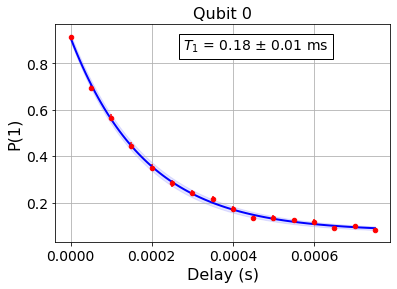

{'value': 0.00018324906847729875,
 'stderr': 5.7401448892369964e-06,
 'unit': 's',
 'label': 'T1',
 'fit': {'popt': array([8.34243526e-01, 1.83249068e-04, 7.54695769e-02]),
  'popt_keys': ['a', 'tau', 'c'],
  'popt_err': array([9.07291006e-03, 5.74014489e-06, 5.81083099e-03]),
  'pcov': array([[ 8.23176970e-05,  6.12269465e-09, -2.34835384e-05],
         [ 6.12269465e-09,  3.29492633e-11, -2.66764007e-08],
         [-2.34835384e-05, -2.66764007e-08,  3.37657568e-05]]),
  'reduced_chisq': 0.6502510474479144,
  'dof': 13,
  'xrange': [0.0, 0.00075],
  'circuit_unit': 'us'},
 'quality': 'bad',
 'success': True}

In [11]:
display(t1_expdata.figure(0))
t1_expdata.analysis_results(0).data()

You can view the results at the [IBM Quantum Experiments pane](https://quantum-computing.ibm.com/experiments) on the cloud.

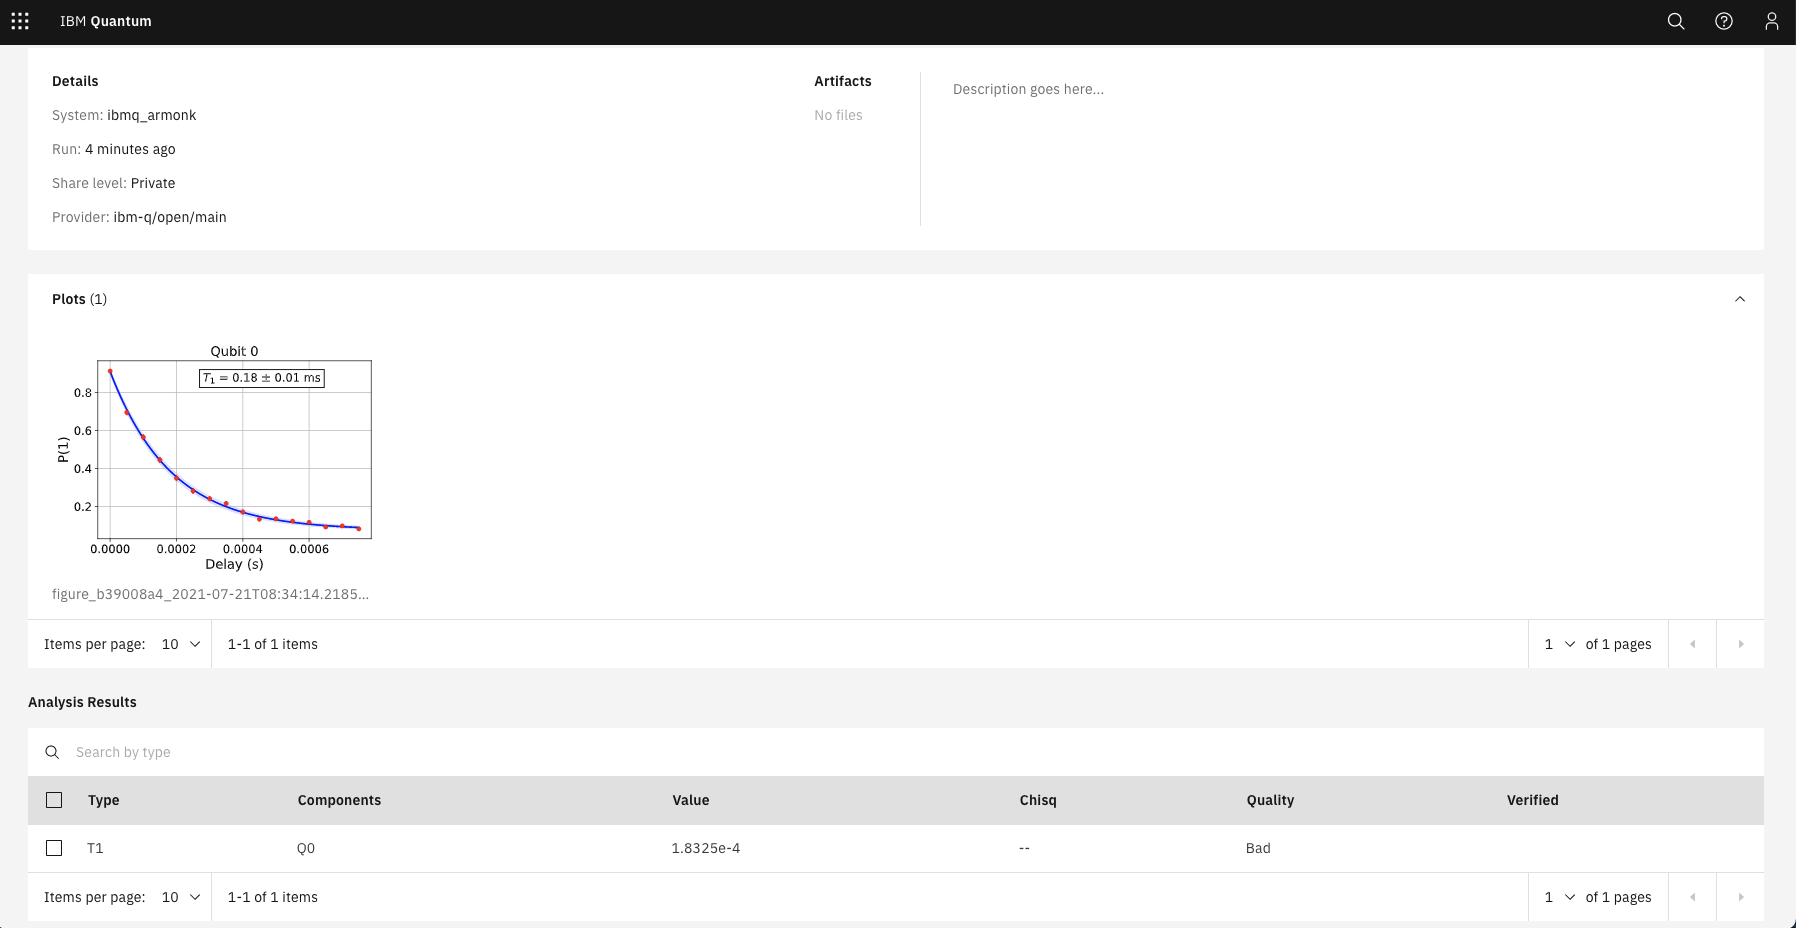

There is also the `auto_save` feature, which saves the data of an experiment preemptively. In the future, you will be able to set `provider.experiment.set_option(auto_save=True)` to turn auto_save on by default at the experiment service level.

In [14]:
exp = T1(qubit=0, delays=t1_delays, unit="us")

t1_expdata = exp.run(backend=backend, shots=1000)
t1_expdata.auto_save = True
t1_expdata.block_for_results()

Not all post-processing has finished. Consider calling save() again after all post-processing is done to save any newly generated data.
Analysis result cannot be saved because no experiment service is available.


## RB Experiment
Let's now do a standard RB experiment and save the results to ResultsDB.

In [19]:
import numpy as np
import qiskit_experiments as qe

rb = qe.library.randomized_benchmarking

lengths = np.arange(1, 1000, 200)
num_samples = 10
seed = 1010

rb_exp = rb.StandardRB([0], lengths, num_samples=num_samples, seed=seed)
rb_expdata = rb_exp.run(backend)
rb_expdata.block_for_results()
rb_expdata.save()

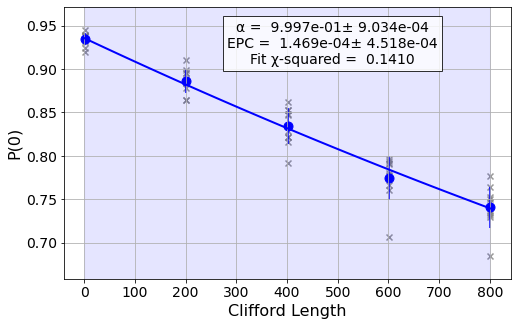

{'analysis_type': 'RBAnalysis',
 'popt': array([9.35656059e-01, 9.99706253e-01, 9.48863844e-19]),
 'popt_keys': ['a', 'alpha', 'b'],
 'popt_err': array([2.60910715e+00, 9.03358822e-04, 2.61131515e+00]),
 'pcov': array([[ 6.80744011e+00,  2.35549302e-03, -6.81317670e+00],
        [ 2.35549302e-03,  8.16057161e-07, -2.35759976e-03],
        [-6.81317670e+00, -2.35759976e-03,  6.81896679e+00]]),
 'reduced_chisq': 0.14095954042430575,
 'dof': 2,
 'xrange': [1.0, 801.0],
 'success': True,
 'EPC': 0.0001468735487230588,
 'EPC_err': 0.00045181212947009546,
 'EPG': {0: {'rz': 0.0,
   'sx': 7.621733241999669e-05,
   'x': 7.621733241999669e-05}}}

In [21]:
display(rb_expdata.figure(0))
rb_expdata.analysis_results(0).data()